In [1]:
from piohmm import HMM
import numpy as np
import torch
import matplotlib.pyplot as plt

### Create a synthetic dataset

In [2]:
n = 100 #number of samples
d = 1 #dimensionality of observations
t = 20 #number of time steps
k = 2 #number of states

In [3]:
A = torch.tensor([[0.6, 0.4],[0.27, 0.73]])
a_dist = torch.distributions.dirichlet.Dirichlet(3 * torch.ones(k))
pi = a_dist.sample()

mu = torch.tensor([0., 2.])#means
var = torch.tensor([0.1, 0.1])#covariance

In [4]:
b = 2

In [5]:
X = torch.zeros((n,t,d))
Z = torch.zeros((n,t), dtype=torch.long)
#D = torch.zeros((n,t))

for i in range(n):
    for j in range(t):
        if j == 0:
            Z[i, j] = torch.multinomial(pi, num_samples=1).byte()
            # D[i, j] = torch.rand(1)
            m_dist = torch.distributions.normal.Normal(
                mu.index_select(0, Z[i, j]),
                var.index_select(0, Z[i, j]))
            X[i, j, :] = m_dist.sample()
        else:
            Z[i, j] = torch.multinomial(A[Z[i, j - 1], :], num_samples=1)
            # D[i, j] = torch.rand(1)
            m_dist = torch.distributions.normal.Normal(
                mu.index_select(0, Z[i, j]),
                var.index_select(0, Z[i, j]))
            X[i, j, :] = m_dist.sample()

X_hat = torch.zeros(n, t, d)

l = 2.5 #lengthscale for the SE kernel
s = 4 #sigma^2 for the SE kernel

#build covariance matrix
var_x = torch.zeros(t,t)
t_vec = torch.range(0,t)
for j in range(t):
    for jj in range(t):
        r = (t_vec[j] - t_vec[jj])**2
        var_x[j, jj] = 1/s*torch.exp(-r/(2*l))

L = torch.cholesky(var_x)
b_stor = torch.zeros(n)


for i in range(n):
    e = torch.randn(t)
    b_stor[i] = 2*b*torch.rand(1) - b
    X_hat[i, :, :] =  torch.einsum('ik,k->i', [L, e])[None, :, None] + X[i, :, :] + b_stor[i]*torch.ones(1,t,1)


/Users/kristen.severson.ibm/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: torch.range is deprecated and will be removed in a future release because its behavior is inconsistent with Python's range builtin. Instead, use torch.arange, which produces values in [start, end).


### Learn model

In [6]:
#fit a personalized hmm
piohmm = HMM(X_hat, k=k, full_cov=False, priorV=False, io=False, personalized=True, personalized_io=False,
                   state_io=False, UT=False, device='cpu', eps=1e-18, priorMu=True, var_fill=0.5)
piohmm_params, _, _, elbo, b_hat, _  = piohmm.learn_model(num_iter=3500, intermediate_save=False)
piohmm_mps, _, _ = piohmm.predict_sequence(piohmm_params, n_sample=b_hat)

piohmm_xhat = np.zeros((n,t))
piohmm_xvar = np.zeros((n,t))
for i in range(n):
    for j in range(t):
        idx = np.where(piohmm_mps[i, j].numpy() == np.arange(k))[0][0]
        piohmm_xhat[i,j] = piohmm_params['mu'][idx].numpy() + b_hat[i].detach().numpy()
        piohmm_xvar[i,j] = 2*np.sqrt(piohmm_params['var'][idx].numpy())

#fit a standard hmm
hmm = HMM(X_hat, k=k, full_cov=False, priorV=False, io=False, personalized=False, personalized_io=False,
             state_io=False, UT=False, device='cpu', eps=1e-18)
hmm_params, _, _ = hmm.learn_model(num_iter=3500, intermediate_save=False)
hmm_mps, _, _ = hmm.predict_sequence(hmm_params)

hmm_xhat = np.zeros((n,t))
hmm_xvar = np.zeros((n,t))
for i in range(n):
    for j in range(t):
        idx = np.where(hmm_mps[i,j].numpy() == np.arange(k))[0][0]
        hmm_xhat[i,j] = hmm_params['mu'][idx].numpy() 
        hmm_xvar[i,j] = 2*np.sqrt(hmm_params['var'][idx].numpy())

/Users/kristen.severson.ibm/PycharmProjects/MJFF/PIOHMM/DiseaseProgressionModeling-HMM/piohmm.py:860: UserWarning: masked_select received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead. (Triggered internally at  ../aten/src/ATen/native/TensorAdvancedIndexing.cpp:733.)
  logA[i, j] = torch.logsumexp(torch.masked_select(xi[i, j, :, :], self.om[:, 1:].byte()), dim=-1) - \
/Users/kristen.severson.ibm/PycharmProjects/MJFF/PIOHMM/DiseaseProgressionModeling-HMM/piohmm.py:861: UserWarning: masked_select received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead. (Triggered internally at  ../aten/src/ATen/native/TensorAdvancedIndexing.cpp:733.)
  torch.logsumexp(torch.masked_select(xi[i, :, :, :], self.om[None, :, 1:].byte()), dim=-1)
/Users/kristen.severson.ibm/PycharmProjects/MJFF/PIOHMM/DiseaseProgressionModeling-HMM/piohmm.py:860: UserWarning: masked_select received a

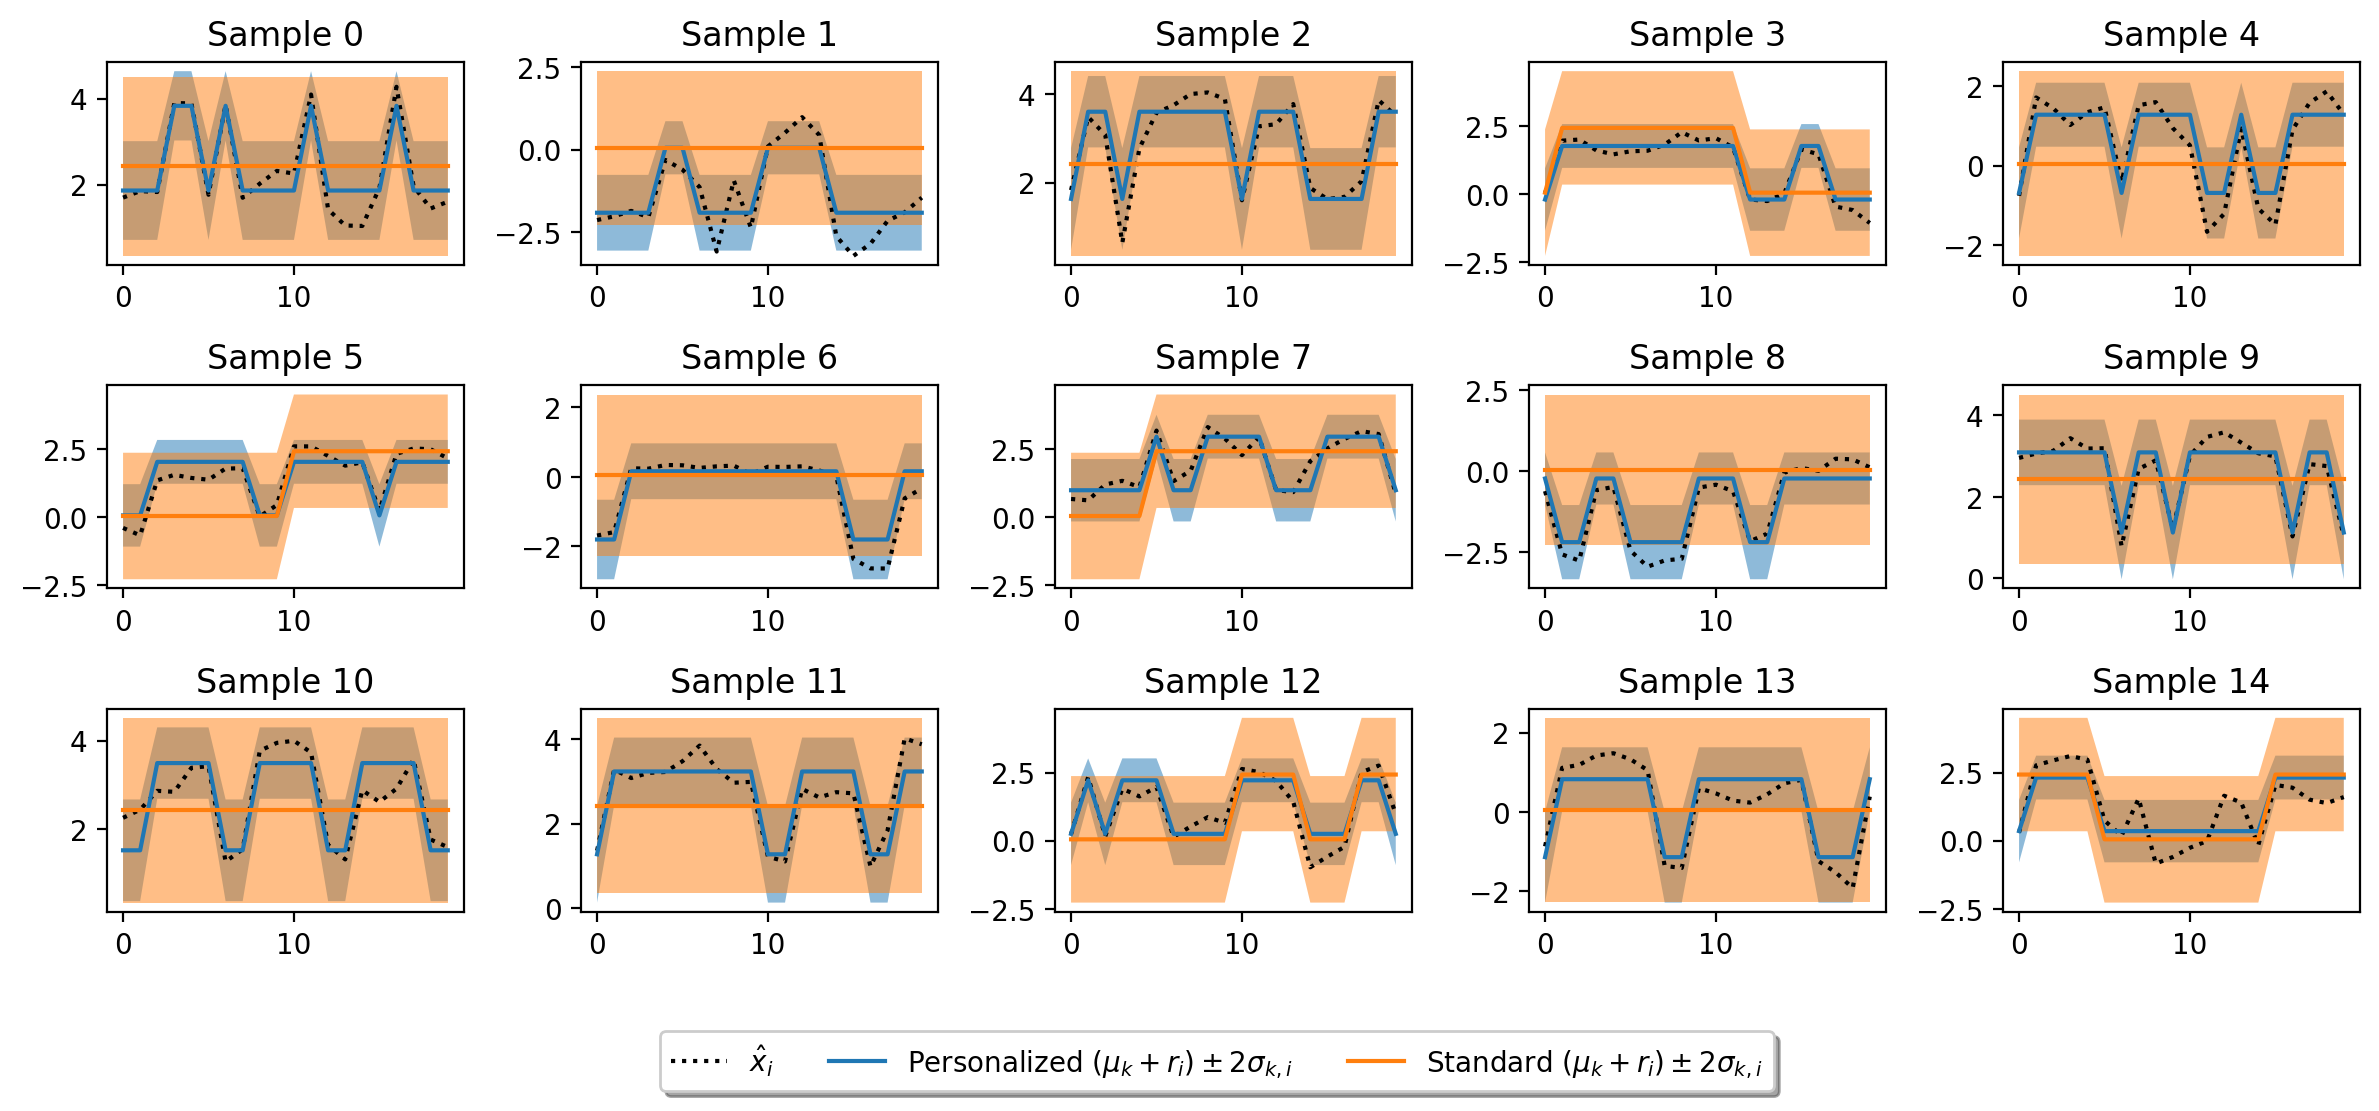

In [10]:
fig, axs = plt.subplots(3,5,dpi=200)
fig.set_size_inches(12,5)
for i, ax in enumerate(axs.flatten()):
    ax.plot(X_hat[i, :].numpy(), 'k:', label='$\hat{x}_i$')
    ax.plot(piohmm_xhat[i, :], label='Personalized $(\mu_k + r_i) \pm 2\sigma_{k,i}$')
    ax.fill_between(np.arange(t), piohmm_xhat[i,:] - piohmm_xvar[i, :], piohmm_xhat[i, :] + piohmm_xvar[i, :], alpha=0.5)
    ax.plot(hmm_xhat[i, :], label='Standard $(\mu_k + r_i) \pm 2\sigma_{k,i}$')
    ax.fill_between(np.arange(t), hmm_xhat[i,:] - hmm_xvar[i, :], hmm_xhat[i, :] + hmm_xvar[i, :], alpha=0.5)
    ax.set_title('Sample ' + str(i))
fig.tight_layout()  
ax.legend(loc='lower center', bbox_to_anchor=(-2.2, -0.95),
          fancybox=True, shadow=True, ncol=5)


(-2.5, 2.5)

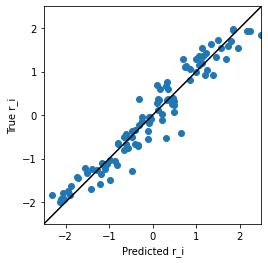

In [17]:
plt.scatter(b_hat.detach().numpy(),b_stor)
plt.plot(np.linspace(-b-0.5,b+0.5),np.linspace(-b-0.5,b+0.5),'k')
plt.axis('square')
plt.xlabel('Predicted r_i')
plt.ylabel('True r_i')
plt.xlim([-b-0.5,b+0.5])
plt.ylim([-b-0.5,b+0.5])